# Prosper Loan Data — Part I: Exploratory Data Analysis
## by Luca Scarpantonio

## Introduction to the Prosper Loan Dataset

In this project, I will analyze the **Prosper Loan Dataset**, a collection of data from *Prosper Marketplace*, a peer-to-peer lending platform.

The dataset contains information on **over 100,000 loans**, with more than 80 variables describing:
- **Loan characteristics** – original loan amount, term, interest rate (BorrowerAPR), and current loan status (LoanStatus).
- **Borrower characteristics** – Prosper score, income range, employment status.
- **Loan performance** – amount paid, outstanding principal, late payments, or defaults.
- **Listing details** – category of the listing (ListingCategory), origination date, and credit risk rating.


## Preliminary Wrangling


In [60]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [61]:
# high-level overview of data shape and composition

loans = pd.read_csv('data/prosperLoanData.csv')

print(loans.shape)
print(loans.dtypes)
print(loans.head(4))

(113937, 81)
ListingKey                      object
ListingNumber                    int64
ListingCreationDate             object
CreditGrade                     object
Term                             int64
                                ...   
PercentFunded                  float64
Recommendations                  int64
InvestmentFromFriendsCount       int64
InvestmentFromFriendsAmount    float64
Investors                        int64
Length: 81, dtype: object
                ListingKey  ListingNumber            ListingCreationDate  \
0  1021339766868145413AB3B         193129  2007-08-26 19:09:29.263000000   
1  10273602499503308B223C1        1209647  2014-02-27 08:28:07.900000000   
2  0EE9337825851032864889A          81716  2007-01-05 15:00:47.090000000   
3  0EF5356002482715299901A         658116  2012-10-22 11:02:35.010000000   

  CreditGrade  Term LoanStatus           ClosedDate  BorrowerAPR  \
0           C    36  Completed  2009-08-14 00:00:00      0.16516   
1         NaN  

### What is the structure of your dataset?

The dataset consists of **1113937 rows and 81 columns** and each row represents a single Prosper loan listing.  

Columns include:
- Loan characteristics (e.g., `LoanOriginalAmount`, `Term`, `LoanStatus`, `BorrowerAPR`),
- Borrower information (e.g., `ProsperScore`, `IncomeRange`, `EmploymentStatus`),
- Loan performance details (e.g., `ClosedDate`, `LoanCurrentDaysDelinquent`).

Data types are a mix of numeric (`int64`, `float64`), object (`string` categories), and datetime (`ListingCreationDate`, `ClosedDate`).

### What is/are the main feature(s) of interest in your dataset?

The main features of interest are:
- **BorrowerAPR** (interest rate): to study its distribution and what factors influence it.
- **LoanStatus**: to understand the performance of loans and the proportion of completed, current, and defaulted loans.
- **LoanOriginalAmount**: to analyze the distribution of loan amounts and how they relate to income or ProsperScore.
- **ProsperScore**: as a key indicator of credit risk and a potential driver of interest rate differences.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

To investigate the main features, I will use:
- **IncomeRange** and **EmploymentStatus** to see if socioeconomic factors affect interest rates or loan amounts.
- **Term** to analyze whether longer terms correlate with higher interest rates or defaults.
- **ListingCategory (numeric)** to explore differences between loan purposes.
- **BorrowerState** to see if geographic factors play a role in loan performance.
- **ProsperScore** to check its relationship with BorrowerAPR and LoanStatus.

### Data Overview
##### Review of Data Consistency
Herein I will review consistency between three major indicator used within in this study and how they relate to each other. Values are expressed in percentage.

In [62]:
pd.crosstab(loans['EmploymentStatus'], loans['IncomeRange'], normalize='index').round(3) * 100

IncomeRange,$0,"$1-24,999","$100,000+","$25,000-49,999","$50,000-74,999","$75,000-99,999",Not displayed,Not employed
EmploymentStatus,,,,,,,,
Employed,0.0,3.9,19.2,27.3,31.1,18.4,0.0,0.0
Full-time,1.1,7.6,11.3,37.4,28.9,13.2,0.4,0.0
Not available,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
Not employed,1.3,1.1,0.1,0.5,0.0,0.0,0.5,96.5
Other,0.0,24.9,3.4,42.4,23.1,6.2,0.0,0.0
Part-time,4.2,65.9,0.4,23.9,3.4,0.9,1.3,0.0
Retired,0.9,36.4,1.3,41.5,16.7,3.1,0.1,0.0
Self-employed,4.2,10.7,20.4,28.5,23.1,12.7,0.4,0.0


In [67]:
# Inconsistency rules
mask_emp_zero_income = (
    loans["EmploymentStatus"].isin(["Employed", "Full-time", "Part-time", "Self-employed", "Retired", "Other"])
    & (loans["IncomeRange"] == "$0")
)
mask_notemp_positive_income = (
    (loans["EmploymentStatus"] == "Not employed")
    & (~loans["IncomeRange"].isin(["$0", "Not displayed"]))
)

n_emp_zero = mask_emp_zero_income.sum()
n_notemp_pos = mask_notemp_positive_income.sum()
n_not_disp = (loans["IncomeRange"] == "Not displayed").sum()
n_ps_na = loans["ProsperScore"].isna().sum()
total = len(loans)

print(f"Total rows: {total:,}")
print(f"Emp-type with $0 income: {n_emp_zero:,} ({n_emp_zero/total:.2%})")
print(f"'Not employed' with income > $0: {n_notemp_pos:,} ({n_notemp_pos/total:.2%})")
print(f"IncomeRange = 'Not displayed': {n_not_disp:,} ({n_not_disp/total:.2%})")
print(f"ProsperScore missing: {n_ps_na:,} ({n_ps_na/total:.2%})")

Total rows: 113,937
Emp-type with $0 income: 610 (0.54%)
'Not employed' with income > $0: 820 (0.72%)
IncomeRange = 'Not displayed': 7,741 (6.79%)
ProsperScore missing: 29,084 (25.53%)


### Observation:
- Borrowers with `Employed` status still report $0 income in some cases.
- Some `Not Employed` borrowers have received a loan and even report a positive income.

While there could be some justification for these data points (e.g. secondary income sources, misreported status), for the purpose of this analysis I will **exclude them from further exploration** to maintain data consistency.

**Decision.** To avoid bias and retain interpretable relationships, I will:
1) drop rows where an *employed-type* has `$0` income;  
2) drop rows where *Not employed* has income > `$0`;  
3) drop `"Not displayed"` income;  
4) drop rows with missing `ProsperScore` (coerced to numeric).

In [69]:

loans_clean = loans.loc[~mask_emp_zero_income & ~mask_notemp_positive_income].copy()

loans_clean = loans_clean[loans_clean["IncomeRange"] != "Not displayed"].copy()

loans_clean["ProsperScore"] = pd.to_numeric(loans_clean["ProsperScore"], errors="coerce")
loans_clean = loans_clean[loans_clean["ProsperScore"].notna()].copy()


print(f"Rows before: {total:,}")
print(f"Rows after cleaning: {len(loans_clean):,}")
print(f"Removed: {total - len(loans_clean):,} ({(total - len(loans_clean))/total:.2%})")

Rows before: 113,937
Rows after cleaning: 84,159
Removed: 29,778 (26.14%)


In [47]:
pd.crosstab(loans_clean['EmploymentStatus'], loans_clean['IncomeRange'], normalize='index').round(3) * 100

IncomeRange,$0,"$1-24,999","$100,000+","$25,000-49,999","$50,000-74,999","$75,000-99,999",Not displayed
EmploymentStatus,,,,,,,
Employed,0.0,3.9,19.2,27.3,31.1,18.4,0.0
Full-time,0.0,7.7,11.5,37.8,29.2,13.4,0.4
Not available,0.0,0.0,0.0,0.0,0.0,0.0,100.0
Not employed,100.0,0.0,0.0,0.0,0.0,0.0,0.0
Other,0.0,24.9,3.4,42.4,23.1,6.2,0.0
Part-time,4.2,65.9,0.4,23.9,3.4,0.9,1.3
Retired,0.9,36.4,1.3,41.5,16.7,3.1,0.1
Self-employed,4.2,10.7,20.4,28.5,23.1,12.7,0.4


##### Not displayed Income Range

Overview of one of the main metrics for this study, `IncomeRange`, to visualize data completeness and consistency. Borrowers could agree to release information about incomes perhaps.

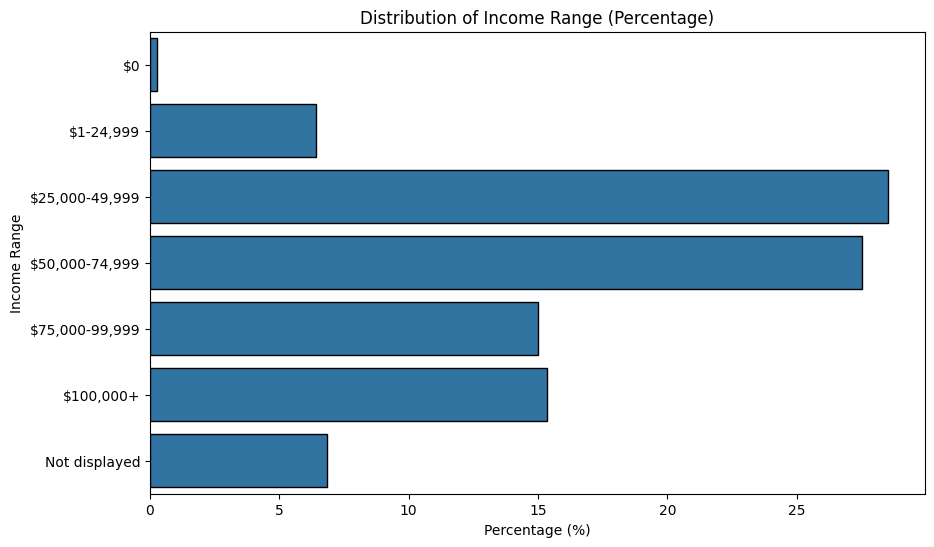

In [48]:
a = loans_clean['IncomeRange'].value_counts()
tot = a.sum()


income_range = [
    '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999',
    '$75,000-99,999', '$100,000+', 'Not displayed'
]
income_pct = (a / tot * 100).reindex(income_range)

plt.figure(figsize=(10, 6))
sns.barplot(x=income_pct.values, y=income_pct.index,  edgecolor='black')
plt.title('Distribution of Income Range (Percentage)')
plt.xlabel('Percentage (%)')
plt.ylabel('Income Range')
plt.show()

##### Observation: Distribution of Income Range

The distribution of `IncomeRange` shows that the majority of borrowers report an income between **$25,000–74,999** (over 50% combined).  
Only **~6% of borrowers did not disclose their income ("Not displayed")**.

Since the "Not displayed" category represents a very small portion of the dataset and does not provide meaningful information for socio-economic analysis, I will **consider dropping these rows** to avoid noise and improve the quality of further visualizations.

> **Decision:** Exclude rows with `IncomeRange = "Not displayed"` from subsequent analysis.

In [49]:
print(f"Rows before Step 1: {len(loans_clean)}")
# True dove IncomeRange è "Not displayed" (case-insensitive) o mancante
mask_not_disp = loans_clean['IncomeRange'].astype('string').str.strip().str.lower().eq('not displayed')
mask_nan_inc  = loans_clean['IncomeRange'].isna()
# Tieni solo le righe “buone”
loans_ir_clean = loans_clean.loc[~(mask_not_disp | mask_nan_inc)].copy()
print(f"Removed 'Not displayed' in IncomeRange: {mask_not_disp.sum()}")
print(f"Removed NaN in IncomeRange: {mask_nan_inc.sum()}")
print(f"Rows after Step 1: {len(loans_ir_clean)}")

Rows before Step 1: 112813
Removed 'Not displayed' in IncomeRange: 7737
Removed NaN in IncomeRange: 0
Rows after Step 1: 105076


##### ProsperScore Missing Value Analysis

Prosper, the peer-to-peer lending platform, launched in 2006.  
However, between 2006 and 2008, Prosper used a different credit grading system and **did not provide the `ProsperScore`** variable.  
In July 2009, Prosper relaunched after a brief pause (to comply with SEC regulations) and introduced **ProsperScore** —  
a proprietary risk score (1–10) developed with Experian to better predict borrower default risk.


Missing ProsperScore: 20897 rows (19.89% of dataset)


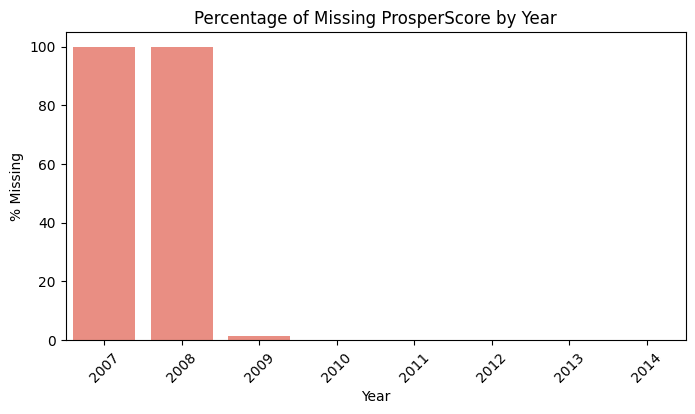

In [50]:
# Count missing values in ProsperScore
missing_count = loans_ir_clean["ProsperScore"].isna().sum()
total_rows = len(loans_ir_clean)
missing_pct = missing_count / total_rows * 100

print(f"Missing ProsperScore: {missing_count} rows ({missing_pct:.2f}% of dataset)")

# Visualize proportion of missing values by year
loans_ir_clean["year"] = pd.to_datetime(loans_ir_clean["ListingCreationDate"], format='mixed').dt.year

missing_by_year = (
    loans_ir_clean.groupby("year")["ProsperScore"]
    .apply(lambda x: x.isna().mean() * 100) 
    .reset_index(name="pct_missing")
)

plt.figure(figsize=(8,4))
sns.barplot(data=missing_by_year, x="year", y="pct_missing", color="salmon")
plt.title("Percentage of Missing ProsperScore by Year")
plt.ylabel("% Missing")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.show()

As a result:
- **Loans before 2009 have missing ProsperScore values.**
- The bar chart below shows that almost all missing values are concentrated in loans originated **before 2009**. Including them would bias any analysis involving ProsperScore, since they would all be dropped during filtering.
- After 2009, ProsperScore is consistently available, which matches the fact that Prosper introduced this score as part of their credit model in mid-2009.


💡 **Decision:** For this analysis, we exclude all loans with `ListingCreationDate < 2009-01-01`, ensuring that `ProsperScore` is complete and consistent across the dataset.

In [51]:
input_df = loans_ir_clean
print(f"Rows before Step 2: {len(input_df)}")
# Convert ProsperScore to numeric, coercing errors to NaN
ps_numeric = pd.to_numeric(input_df['ProsperScore'], errors='coerce')
removed_ps = ps_numeric.isna().sum()
# keep only rows with valid ProsperScore
loans_clean = input_df.loc[ps_numeric.notna()].copy()
loans_clean['ProsperScore'] = ps_numeric.loc[ps_numeric.notna()].astype(float)
loans_clean.reset_index(drop=True, inplace=True)
print(f"Removed rows due to missing/invalid ProsperScore: {removed_ps}")
print(f"Rows after Step 2: {len(loans_clean)}")

Rows before Step 2: 105076
Removed rows due to missing/invalid ProsperScore: 20897
Rows after Step 2: 84179


## Univariate Exploration


### Question 1
How does the loan term (12, 36, 60 months) affect the characteristics of the loans?

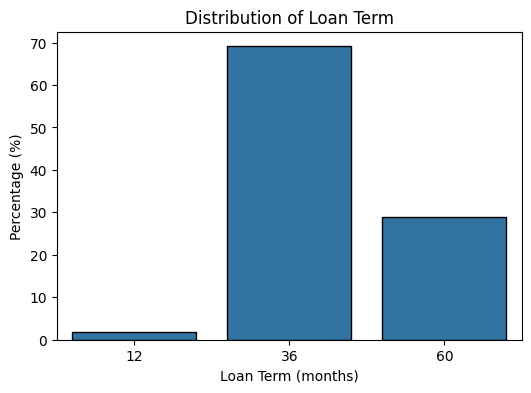

In [53]:
loans_clean['Term'] = loans_clean['Term'].astype('category')


plt.figure(figsize=(6,4))
sns.countplot(data=loans_clean, x='Term', edgecolor='black',stat='percent')
plt.title('Distribution of Loan Term')
plt.xlabel('Loan Term (months)')
plt.ylabel('Percentage (%)')
plt.show()

### Question 2
What is the distribution of Borrower APR (interest rate) among the loans?


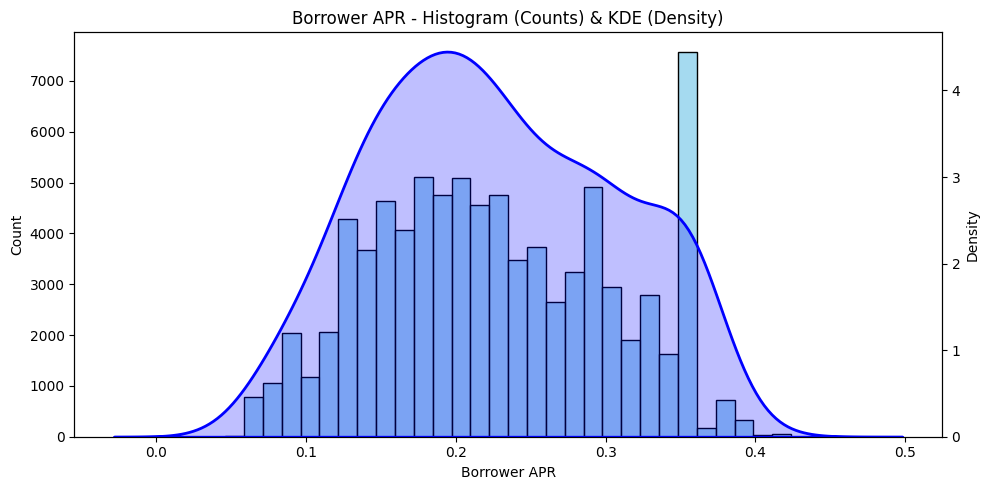

In [28]:
fig, ax1 = plt.subplots(figsize=(10,5))

# Istogramma sui conteggi (asse sinistro)
sns.histplot(loans_clean['BorrowerAPR'], bins=30, color='skyblue', edgecolor='black', ax=ax1)
ax1.set_ylabel("Count")
ax1.set_xlabel("Borrower APR")

# Secondo asse per la densità
ax2 = ax1.twinx()
sns.kdeplot(loans_clean['BorrowerAPR'], bw_adjust=3, color='blue', fill='blue', ax=ax2, lw=2)
ax2.set_ylabel("Density")
ax2.grid(False)  # per non duplicare la griglia

plt.title("Borrower APR - Histogram (Counts) & KDE (Density)")
plt.tight_layout()
plt.show()

### Observations
- The distribution is right-skewed: most loans have APRs between **0.1 and 0.35**.
- There are a few loans with extremely low APRs (close to 0) and some very high ones (above 0.4).
- This could indicate different risk profiles or loan categories (e.g., low risk vs high risk borrowers).

### Question 3
What is the distribution of Loan Original Amount?

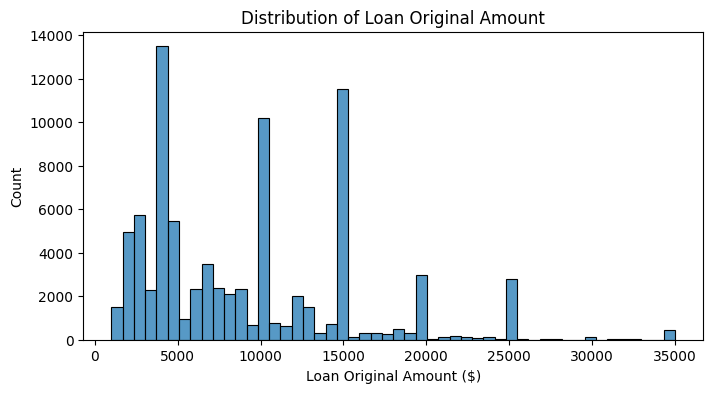

In [29]:
plt.figure(figsize=(8, 4))
sns.histplot(data=loans_clean, x="LoanOriginalAmount", bins= 50)
plt.title("Distribution of Loan Original Amount")
plt.xlabel("Loan Original Amount ($)")
plt.ylabel("Count")
plt.show()

### Observations
- The distribution shows clear peaks at **common loan amounts** (e.g., $5,000, $10,000, $15,000).
- This suggests standard loan amounts are offered by Prosper rather than arbitrary values.
- The distribution is slightly right-skewed, with fewer very large loans.

### Question 4

What is the distribution of Prosper Score?

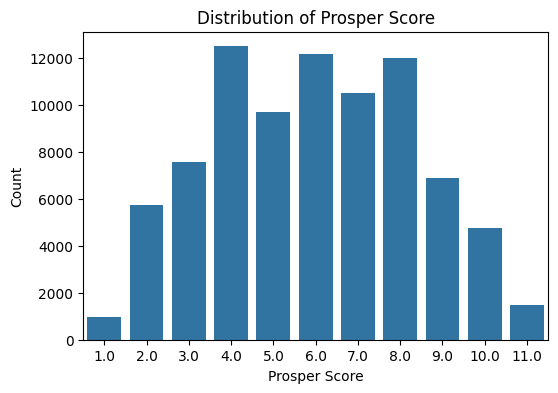

In [72]:
plt.figure(figsize=(6, 4))
sns.countplot(data=loans_clean, x="ProsperScore")
plt.title("Distribution of Prosper Score")
plt.xlabel("Prosper Score")
plt.ylabel("Count")
plt.show()

### Observations
- Prosper Scores range from **1 to 11**.
- The distribution is approximately uniform, though some scores are slightly more frequent.
- This variable will be very useful to analyze credit risk and its relationship to interest rates.

### Question 5

Which class of Employee are likely not able to repay a morgage?

In [57]:
pivot_table = loans_clean.pivot_table(
    values='LoanCurrentDaysDelinquent',
    index='EmploymentStatus',
    columns='IncomeRange',
    aggfunc='mean'
)

pivot_table = pivot_table.round(0)

import pandas as pd
from IPython.display import display

print("Loan Delinquency by Employment Status and Income Range (Average Delinquent Days)")

display(pivot_table.style.background_gradient(cmap='coolwarm', axis=None).format("{:.0f}"))

Loan Delinquency by Employment Status and Income Range (Average Delinquent Days)


IncomeRange,$0,"$1-24,999","$100,000+","$25,000-49,999","$50,000-74,999","$75,000-99,999"
EmploymentStatus,,,,,,
Employed,nan,63,13,41,23,19
Full-time,nan,154,62,119,96,71
Other,nan,64,29,37,19,18
Part-time,4,93,nan,131,308,0
Retired,nan,142,0,173,40,239
Self-employed,257,82,41,54,47,31


### Observations:


##### Loan Delinquency by Employment Status and Income Range
This heatmap visualizes the **average number of delinquent days** across different combinations of
`EmploymentStatus` and `IncomeRange`.
**Key Observations:**
- **Higher Delinquency Among Self-Employed Borrowers:**  
 The self-employed group with `IncomeRange = "$0"` shows the **highest average delinquency days (634)**,
 suggesting this subgroup may represent borrowers with unstable or unreported income sources.
- **Full-Time Employees with Lower Income Have Higher Delinquency:**  
 Full-time borrowers in the lowest income brackets (`$0` and `$1–24,999`)
 show much higher delinquency days compared to higher income ranges,
 indicating that income level plays a critical role in loan repayment capability.
- **Lower Delinquency for Higher Income Groups:**  
 Across most employment statuses, delinquency days **decrease as income range increases**,
 confirming that higher income improves repayment performance.
- **Retired Borrowers Show Mixed Behavior:**  
 Interestingly, retirees display high delinquency for `$75,000–99,999`,
 which may be due to a small number of high-value defaults skewing the average.
**Takeaway:**  
Delinquency patterns are strongly correlated with **socio-economic status**.  
Borrowers with low or no income, especially self-employed, pose the highest credit risk,
and this insight could be used to refine risk models or lending criteria.

In [58]:
# Generate a summary table of delinquency stats
pivot_stats = loans_clean.pivot_table(
    values='LoanCurrentDaysDelinquent',
    index='EmploymentStatus',
    columns='IncomeRange',
    aggfunc=['mean', 'std', 'count']
).round(2)

display(pivot_stats)

mean                                                    \
IncomeRange          $0 $1-24,999 $100,000+ $25,000-49,999 $50,000-74,999   
EmploymentStatus                                                            
Employed            NaN     62.82     13.17          40.76          23.30   
Full-time           NaN    153.77     62.46         119.42          95.80   
Other               NaN     63.88     28.84          36.73          18.51   
Part-time           3.8     92.64       NaN         130.73         308.08   
Retired             NaN    142.30      0.00         172.94          40.31   
Self-employed     257.2     82.26     40.53          53.51          46.64   

                                    std                                     \
IncomeRange      $75,000-99,999      $0 $1-24,999 $100,000+ $25,000-49,999   
EmploymentStatus                                                             
Employed                  18.93     NaN    177.37     79.75         143.67   
Full-time                 71.11     NaN    356.33    239.36         310.60   
Other                     17.76     NaN    170.43    116.15         132.07   
Part-time                  0.00    5.76    287.60       NaN         306.75   
Retired                  239.00     NaN    348.80       NaN         352.49   
Self-employed             30.83  288.97    194.04    150.37         182.94   

                                               count                      \
IncomeRange      $50,000-74,999 $75,000-99,999    $0 $1-24,999 $100,000+   
EmploymentStatus                                                           
Employed                 108.63          99.44   NaN    2651.0   12951.0   
Full-time                277.48         253.14   NaN     415.0    1137.0   
Other                     88.45          94.53   NaN     947.0     128.0   
Part-time                532.43            NaN   5.0     160.0       NaN   
Retired                  177.95         458.90   NaN     111.0       1.0   
Self-employed            169.71         138.60  15.0     370.0     988.0   

                                                               
IncomeRange      $25,000-49,999 $50,000-74,999 $75,000-99,999  
EmploymentStatus                                               
Employed                18367.0        20952.0        12379.0  
Full-time                2610.0         2529.0         1221.0  
Other                    1615.0          881.0          235.0  
Part-time                  78.0           12.0            1.0  
Retired                   160.0           81.0           14.0  
Self-employed            1345.0         1172.0          648.0

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The distribution of **BorrowerAPR** is right-skewed, with most loans having APR between 0.1 and 0.35 but some extreme high values above 0.4.  
The **LoanOriginalAmount** distribution shows clear peaks at round values such as 5,000, 10,000, and 15,000 USD, indicating that Prosper offers loans in standard increments rather than arbitrary amounts.  
**ProsperScore** ranges from 1 to 11; missing values (NaN) concentrated almost entirely in loans originated before 2009 have been neglected.

I did not perform any mathematical transformations (e.g., log transformation) because the variables are already interpretable in their current scale.  
However, I will filter the dataset to include only loans with a valid ProsperScore for subsequent analyses, to ensure comparisons are consistent and not biased by missing values.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Yes — the most unusual pattern was that **ProsperScore is missing for a large number of loans before 2009**.  
This is not a random issue but rather a result of Prosper introducing this score only in mid-2009.  

To avoid distorting relationships between ProsperScore and other features (such as BorrowerAPR, LoanStatus, or LoanOriginalAmount),  
I created a **filtered dataset** that excludes loans with missing ProsperScore.  
This ensures that analyses are based only on loans where ProsperScore is available and comparable.

## Bivariate Exploration

### Question 6
What are the socio-economic condition of loaners and how the interest rate may relate to it?

/var/folders/sn/xrsxvpkj4bx6b_6m3_7zbjz80000gn/T/ipykernel_8576/2952600607.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
/var/folders/sn/xrsxvpkj4bx6b_6m3_7zbjz80000gn/T/ipykernel_8576/2952600607.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)


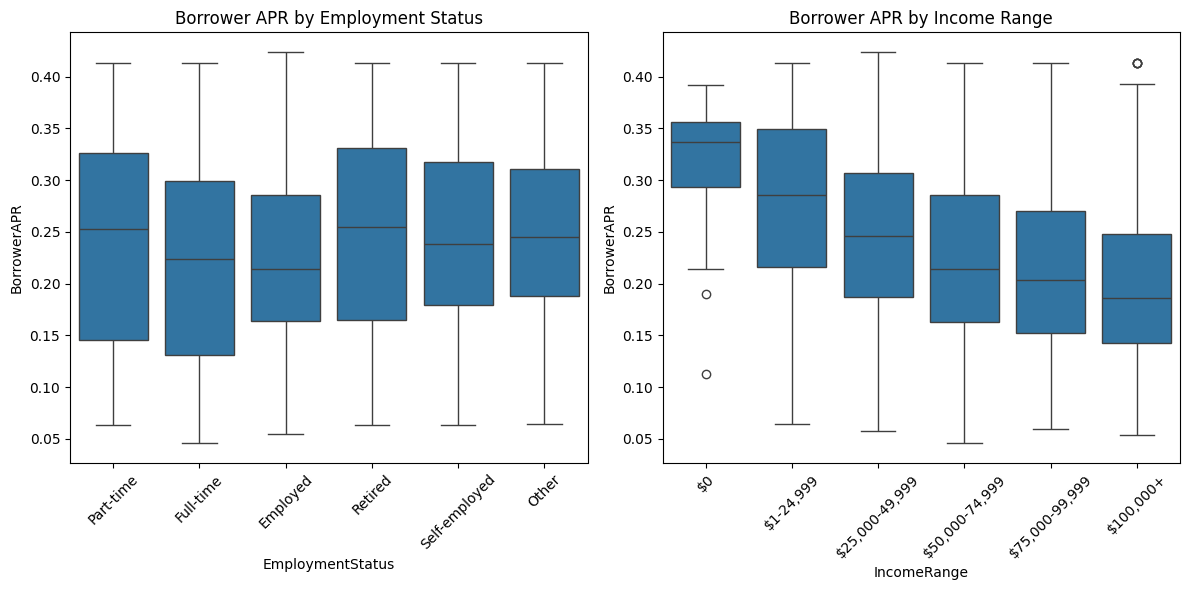

In [33]:
employment_order = [
    'Part-time','Full-time','Employed', 'Retired','Self-employed', 
    'Other'
]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=loans_clean, x='EmploymentStatus', y='BorrowerAPR', ax=ax[0], order=employment_order)
ax[0].set_title("Borrower APR by Employment Status")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

sns.boxplot(data=loans_clean, x='IncomeRange', y='BorrowerAPR', ax=ax[1], order=income_order)
ax[1].set_title("Borrower APR by Income Range")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show();

### Observations: Socio-Economic Analysis - Borrower APR by Employment Status and Income Range

The boxplots above provide insights into how **employment status** and **income range** relate to `BorrowerAPR` (interest rate):

**Key Observations:**

- **Employment Status:**
  - Borrowers who are *not employed* or in the *"Other"* category generally face **higher median APRs**, suggesting higher perceived credit risk.
  - *Retired* borrowers also show a slightly higher APR spread, though with fewer outliers.
  - *Employed* and *full-time* borrowers have **lower median APRs**, indicating better credit profiles.

- **Income Range:**
  - Borrowers with **lower income ranges ($0–$24,999)** tend to have **higher APRs**, reflecting greater risk or lower creditworthiness.
  - As income increases, APR tends to decrease slightly, with the **$100,000+ group showing the lowest median APR**.
  - The variance (IQR) is wide for all income groups, indicating that APR is influenced by multiple factors, not just income.

**Interpretation:**
These plots confirm that socio-economic factors like income and employment have a noticeable impact on loan interest rates.  
Borrowers with stable jobs and higher income ranges generally receive more favorable APRs, which aligns with expectations of lower credit risk.

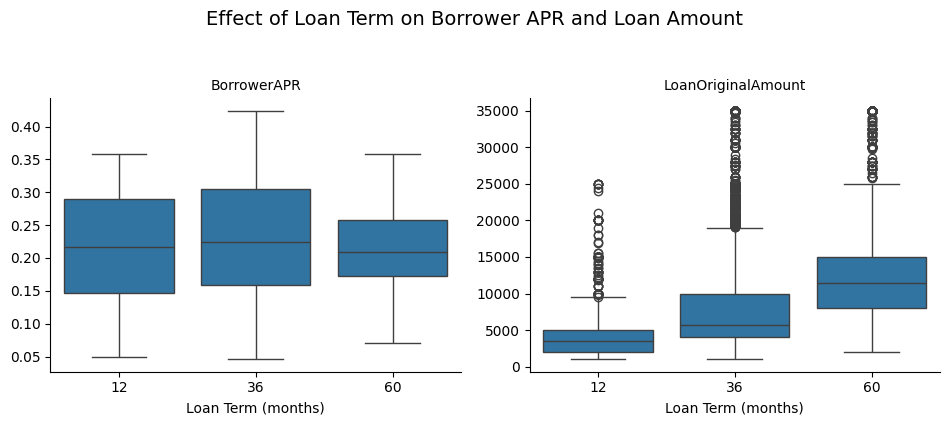

In [34]:
g = sns.FacetGrid(loans_clean.melt(id_vars=['Term'], value_vars=['BorrowerAPR','LoanOriginalAmount']),
                  col="variable", sharex=False, sharey=False, height=4, aspect=1.2)

g.map_dataframe(sns.boxplot, x="Term", y="value")
g.set_axis_labels("Loan Term (months)", "")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=0)

plt.suptitle("Effect of Loan Term on Borrower APR and Loan Amount", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

### Observations:
- Borrower APR:
    - Short-term loans (12 months) have slightly higher interest rates on average.
	- Longer-term loans (36–60 months) show lower median APRs but have a wider spread, suggesting greater diversity of borrower profiles.
- Loan Amount:
    - Loans with 60-month terms have the highest median amounts, consistent with the idea that larger loans require longer repayment horizons.
    - 12-month loans are typically for much smaller amounts, suggesting they are used for short-term or emergency funding.

### Question 7

What is the overall distribution of loan statuses and how does it relate to interest rates and risk scores?

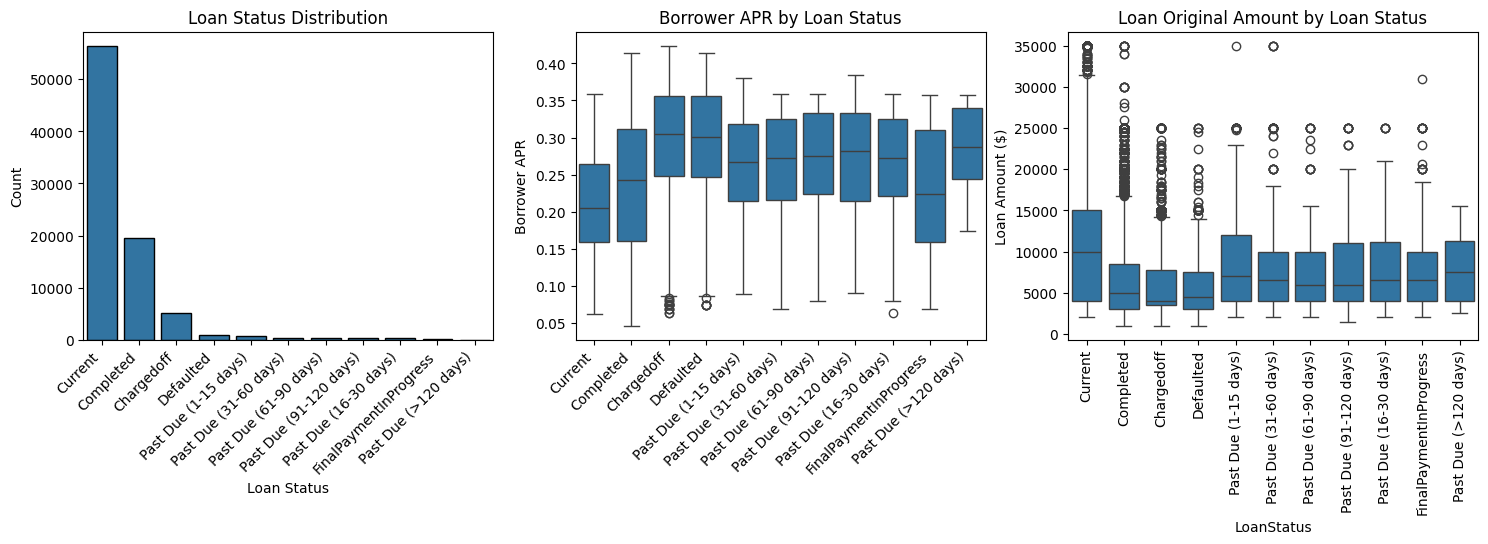

In [35]:
plt.figure(figsize=(18, 4))


plt.subplot(1, 3, 1)
sns.countplot(data=loans_clean, x='LoanStatus', order=loans_clean['LoanStatus'].value_counts().index, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.boxplot(data=loans_clean, x='LoanStatus', y='BorrowerAPR', order=loans_clean['LoanStatus'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Borrower APR by Loan Status')
plt.xlabel('')
plt.ylabel('Borrower APR')

plt.subplot(1, 3, 3)
sns.boxplot(data=loans_clean, x='LoanStatus', y='LoanOriginalAmount', order=loans_clean['LoanStatus'].value_counts().index, )
plt.title("Loan Original Amount by Loan Status")
plt.xticks(rotation=90)
plt.ylabel("Loan Amount ($)")
plt.show()

plt.show();

### Observations

- **Distribution:** The majority of loans are marked as **Completed**, followed by **Current** loans. Delinquent loans (Past Due) and **Chargedoff** represent a smaller proportion, but they are critical for risk analysis.
- **Borrower APR:** Loans in the **Chargedoff** and **Defaulted** categories have noticeably **higher APRs**, confirming that high-risk borrowers tend to pay higher interest rates. Completed loans generally have lower APRs.
- **Loan Amounts:** Completed and Current loans tend to have **higher loan amounts**, while delinquent or defaulted loans show slightly lower median values but wider dispersion.
- **Predictive Insight:** These plots confirm that **ProsperScore** and **APR** could be useful predictors of loan default risk, as higher APR is correlated with non-performing loans.

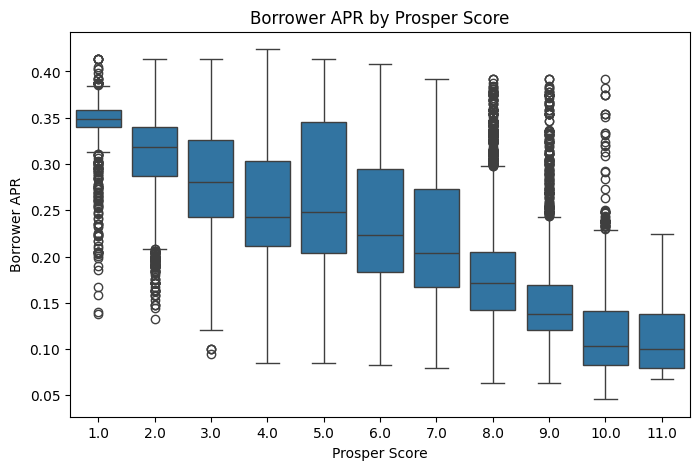

In [36]:
plt.figure(figsize=(8,5))
sns.boxplot(data=loans_clean, x="ProsperScore", y="BorrowerAPR")
plt.title("Borrower APR by Prosper Score")
plt.xlabel("Prosper Score")
plt.ylabel("Borrower APR")
plt.show()

#### Outliers weigth

In [37]:
q1 = loans_clean.groupby("ProsperScore")["BorrowerAPR"].quantile(0.25)
q3 = loans_clean.groupby("ProsperScore")["BorrowerAPR"].quantile(0.75)
iqr = q3 - q1

outlier_mask = loans_clean.apply(
    lambda row: (row["BorrowerAPR"] < q1[row["ProsperScore"]] - 1.5 * iqr[row["ProsperScore"]]) |
                (row["BorrowerAPR"] > q3[row["ProsperScore"]] + 1.5 * iqr[row["ProsperScore"]]),
    axis=1
)

outlier_counts = loans_clean[outlier_mask].groupby("ProsperScore").size()
outlier_pct = (outlier_counts / loans_clean.groupby("ProsperScore").size()) * 100

print(outlier_pct)

ProsperScore
1.0     13.995943
2.0      2.328839
3.0      0.052875
4.0           NaN
5.0           NaN
6.0           NaN
7.0           NaN
8.0      3.865097
9.0      2.934340
10.0     1.306088
11.0          NaN
dtype: float64


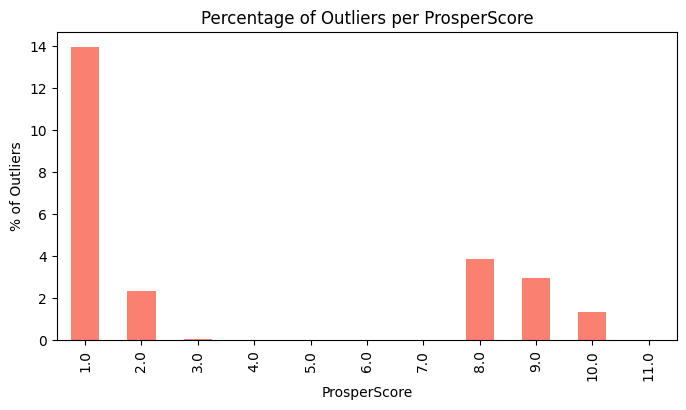

In [38]:
outlier_pct.plot(kind="bar", color="salmon", figsize=(8,4))
plt.title("Percentage of Outliers per ProsperScore")
plt.ylabel("% of Outliers")
plt.xlabel("ProsperScore")
plt.show();

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

The analysis of outliers by ProsperScore reveals that extreme values are not evenly distributed:

- **ProsperScore = 1** has the **highest concentration of outliers (≈14%)**, which is unusually high. This means a significant proportion of loans in the lowest credit category have APRs that deviate strongly from the typical range for this group.

- Scores 8 and 9 also show a moderate percentage of outliers (≈3–4%), but their impact on the overall distribution is much smaller compared to ProsperScore = 1.

- Scores 4–7 have virtually no outliers, suggesting a much more stable distribution.

Because of this pattern, **the mean APR might be skewed by these extreme values**, especially for ProsperScore = 1. The **median APR** is a better measure of central tendency for comparing credit risk categories.

The chart above illustrates the percentage of outliers for each ProsperScore group, highlighting that the majority of extreme cases are concentrated among the lowest scores.



### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?


##### Bivariate Relationship: BorrowerAPR vs. LoanOriginalAmount

To explore whether interest rates are associated with loan sizes, we plot `BorrowerAPR` versus `LoanOriginalAmount`.  
This scatterplot helps reveal whether higher loan amounts correspond to lower APRs, as might be expected due to lower perceived risk for larger (often better-qualified) borrowers.

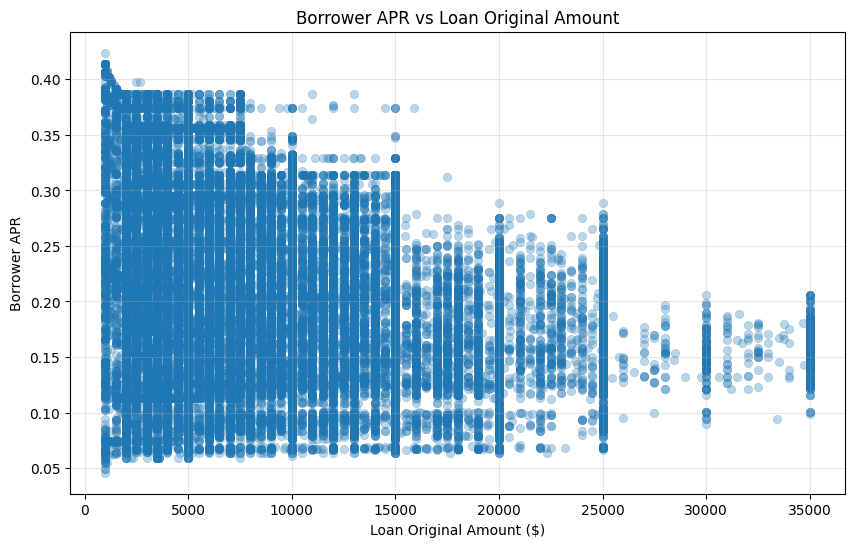

In [74]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=loans_clean, x="LoanOriginalAmount", y="BorrowerAPR",
                alpha=0.3, edgecolor=None)

plt.title("Borrower APR vs Loan Original Amount")
plt.xlabel("Loan Original Amount ($)")
plt.ylabel("Borrower APR")
plt.grid(alpha=0.3)
plt.show()

### Multivariate Exploration: BorrowerAPR by Loan Amount and ProsperScore

Here, we visualize how interest rates (`BorrowerAPR`) vary with both `LoanOriginalAmount` and `ProsperScore`.  
We use a FacetGrid to create multiple scatterplots split by `ProsperScore`, allowing us to examine if the relationship between loan amount and APR is consistent across credit risk levels.

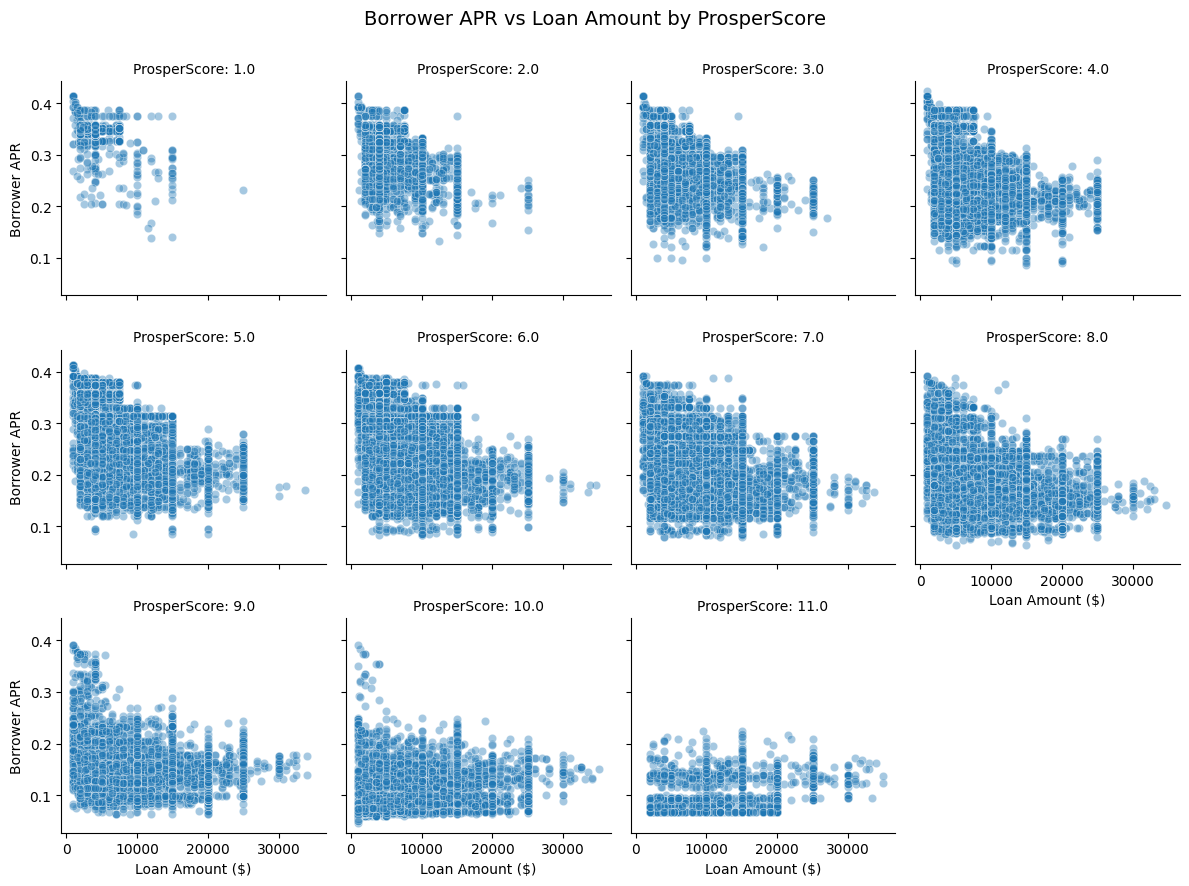

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to avoid extreme outliers for better visualization
df_filtered = loans_clean[loans_clean['LoanOriginalAmount'] < 35000]

g = sns.FacetGrid(df_filtered, col="ProsperScore", col_wrap=4, height=3, sharey=True)
g.map_dataframe(sns.scatterplot, x="LoanOriginalAmount", y="BorrowerAPR", alpha=0.4)
g.set_axis_labels("Loan Amount ($)", "Borrower APR")
g.set_titles("ProsperScore: {col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Borrower APR vs Loan Amount by ProsperScore", fontsize=14)
plt.show()

**Observation:**  
Across all ProsperScore levels, we observe a general **negative relationship** between `LoanOriginalAmount` and `BorrowerAPR`:  
larger loans tend to have lower APRs.  

This trend is **more pronounced for higher ProsperScore borrowers** (lower credit risk), where APRs are tightly clustered at the lower end.  
For low ProsperScore borrowers (1–4), APRs remain high regardless of loan amount, reflecting higher credit risk.

To further investigate relationships between features beyond my main variables of interest, I created a PairGrid using a random sample of 5,000 loans and focusing on five key variables:  

- **ProsperScore**
- **BorrowerAPR**
- **LoanOriginalAmount**
- **DebtToIncomeRatio**
- **StatedMonthlyIncome**

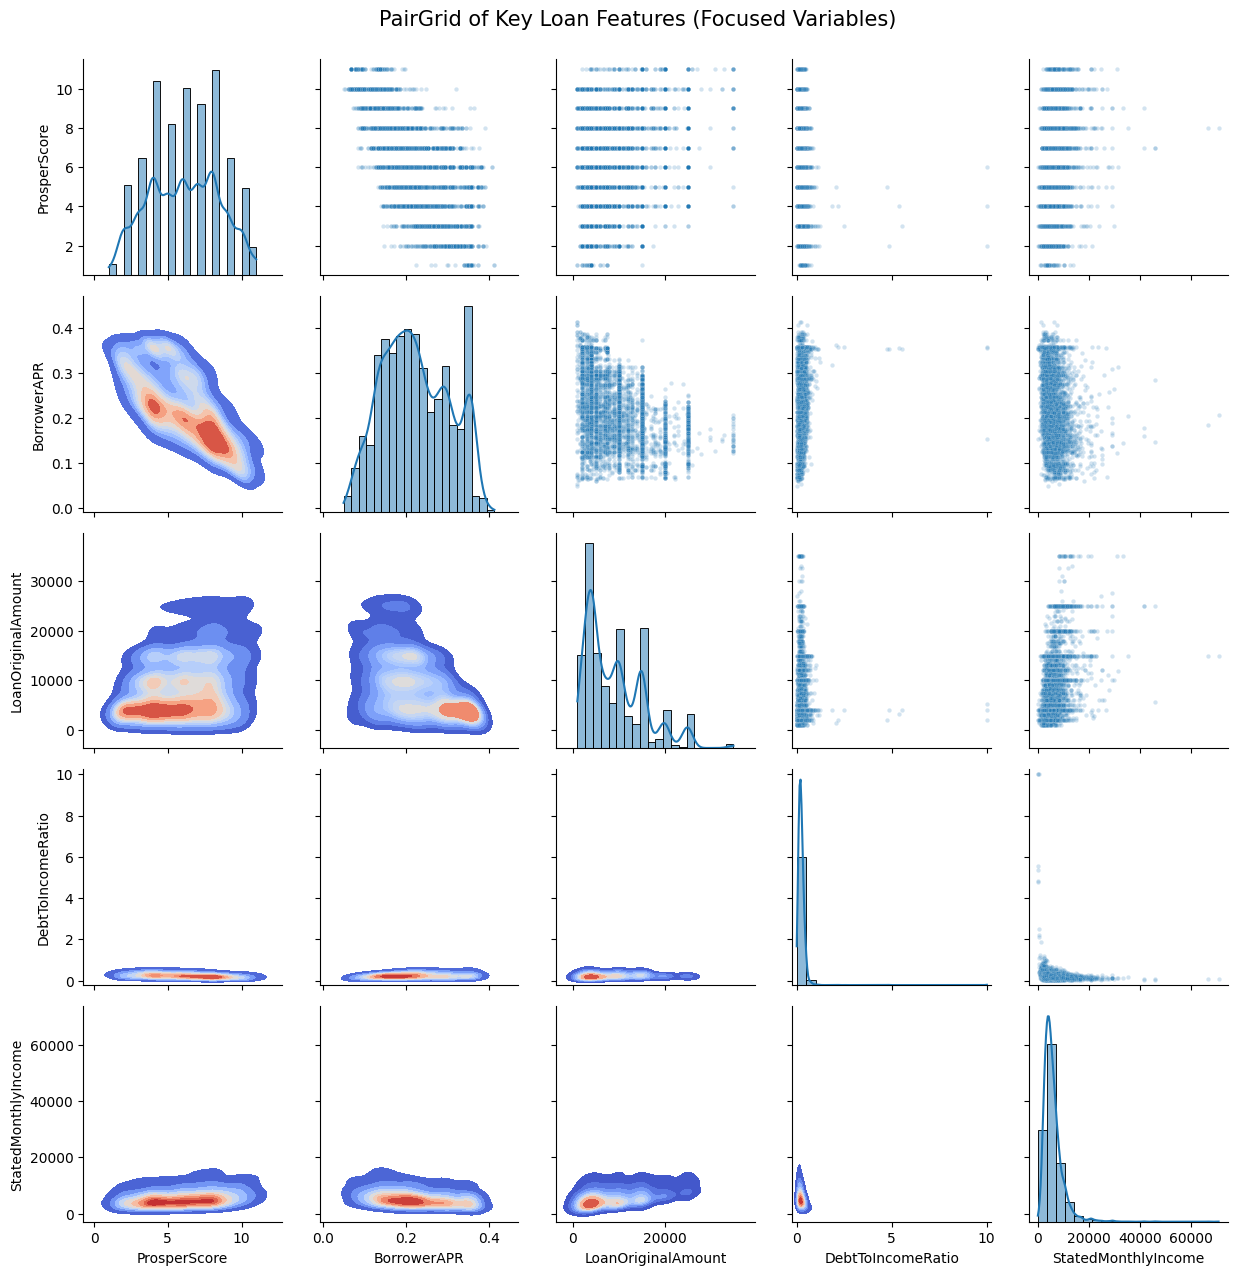

In [ ]:

cols_keys = ['ProsperScore', 'BorrowerAPR', 'LoanOriginalAmount', 'DebtToIncomeRatio', 'StatedMonthlyIncome']
df_keys = loans_clean[cols_keys].dropna()

# Sampling data to improve plotting perfomance
np.random.seed(42)
sample_idx = np.random.choice(df_keys.index, size=5000, replace=False)
df_small = df_keys.loc[sample_idx]

g = sns.PairGrid(df_small,diag_sharey=False, height=2.5)
g.map_upper(sns.scatterplot, alpha=0.2, s=10)
g.map_diag(sns.histplot, kde=True, bins=20)
g.map_lower(sns.kdeplot, fill=True, cmap='coolwarm')

plt.suptitle("PairGrid of Key Loan Features (Focused Variables)", y=1.02, fontsize=15)
plt.show();

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

- **ProsperScore vs BorrowerAPR** shows a strong negative relationship: higher scores are clearly associated with lower interest rates, confirming ProsperScore as a reliable credit risk indicator.
- **LoanOriginalAmount vs ProsperScore** indicates that borrowers with higher scores tend to receive slightly larger loans, though the distribution remains quite spread.
- **DebtToIncomeRatio** is highly right-skewed, with most borrowers concentrated near very low ratios; this should be considered when modeling to avoid distortion by extreme values.
- **StatedMonthlyIncome** has a long right tail with a few extreme outliers that might need capping or log transformation for modeling purposes.

Overall, this grid highlights which feature pairs have strong or potentially interesting relationships and helps prioritize variables for deeper modeling and hypothesis testing.

### Were there any interesting or surprising interactions between features?

Yes, a few interactions stood out in the multivariate analysis:

- **ProsperScore, BorrowerAPR, and LoanOriginalAmount** interact in a meaningful way:
    - Higher ProsperScores are associated with lower BorrowerAPR *and* slightly larger loans.
    - This suggests that creditworthiness not only lowers borrowing costs but also enables access to higher loan amounts.
- **DebtToIncomeRatio** shows little interaction with ProsperScore or BorrowerAPR for most borrowers, but a small group with extreme ratios (>2) tends to have higher interest rates and lower loan amounts, which might indicate higher risk being priced into the loan.
- **StatedMonthlyIncome** interacts with LoanOriginalAmount as expected: higher incomes are correlated with larger loan sizes, but the presence of extreme outliers suggests some income values might be misreported or require transformation.

Overall, the most surprising finding was how strong the negative correlation between ProsperScore and BorrowerAPR is across the entire distribution, reinforcing ProsperScore as the dominant feature for interest rate prediction.

## Conclusions

In this exploratory analysis, I investigated the Prosper Loan dataset to understand key factors influencing loan performance and borrower risk.

- **Data Wrangling:**  
  I first inspected the structure of the dataset, handled missing values (notably in `ProsperScore` before 2009), and selected relevant numeric and categorical features for analysis.

- **Univariate Exploration:**  
  I explored distributions of `BorrowerAPR`, `LoanOriginalAmount`, `ProsperScore`, and other key variables.  
  - `BorrowerAPR` was right-skewed, with most borrowers having interest rates between 0.1 and 0.3.  
  - `ProsperScore` was uniformly distributed between 1 and 11, confirming its usefulness as a credit risk indicator.

- **Bivariate and Multivariate Exploration:**  
  - Found a **strong negative correlation** between `ProsperScore` and `BorrowerAPR`: higher scores are linked to significantly lower interest rates.  
  - Observed that higher `ProsperScore` borrowers tend to qualify for larger loans.  
  - Identified that `DebtToIncomeRatio` had a limited relationship with APR, but extreme values correlated with riskier loans.

Below is a violin plot showing the relationship between `BorrowerAPR` and `ProsperScore`, confirming that higher scores correspond to consistently lower APR values:


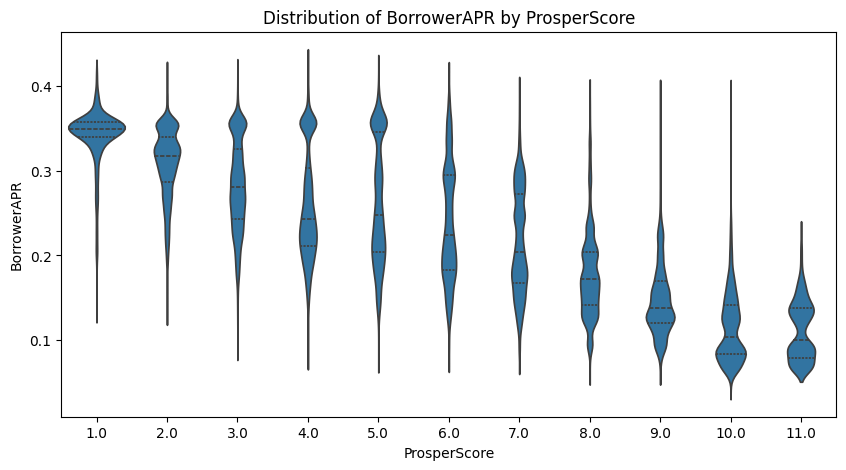

In [ ]:
plt.figure(figsize=(10,5))
sns.violinplot(data=loans_clean, x='ProsperScore', y='BorrowerAPR',  inner='quartile')
plt.title('Distribution of BorrowerAPR by ProsperScore')
plt.xlabel('ProsperScore')
plt.ylabel('BorrowerAPR')
plt.show();